## Comparison 1 (ODEM)
Chakraborty, B., Chaterjee, A., Malakar, S., & Sarkar, R. (2022). An iterative approach to unsupervised outlier detection using ensemble method and distance-based data filtering. Complex & Intelligent Systems, 8(3215–3230). https://doi.org/10.1007/s40747-022-00674-0 (ODEM)

   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0
All clusters filtered out during refinement.
Silhouette Score: 0.2378659671183054
Davies-Bouldin Index: 1.5933034982589624
S/DB Ratio: 0.14929105934822007
Number of Outliers: 1132
Percentage of Outliers: 79.66%
AUC Value: 1.0


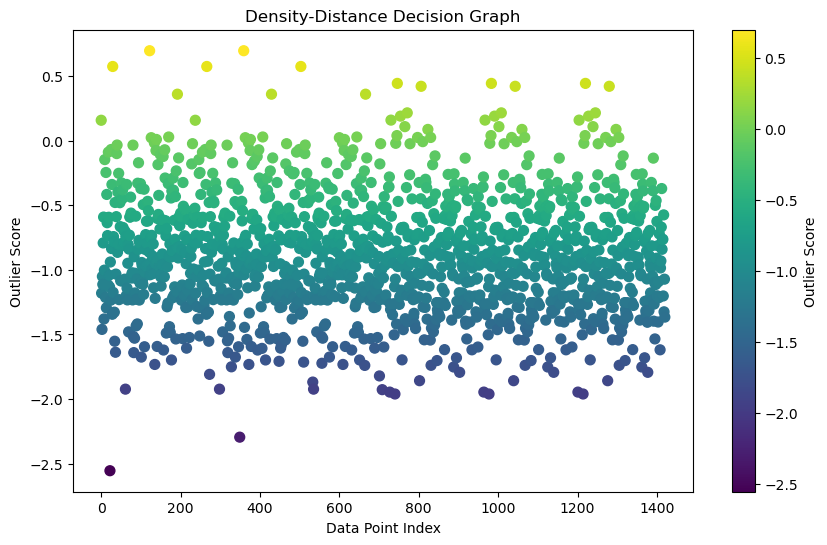

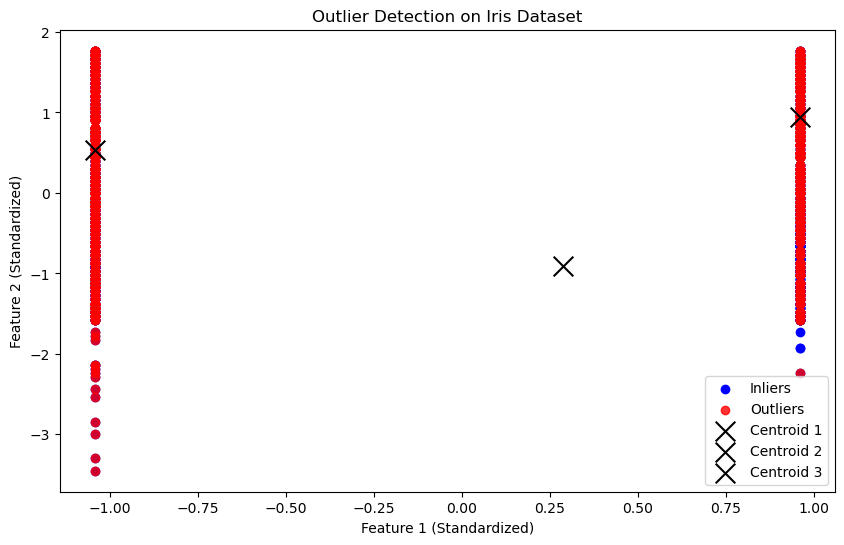

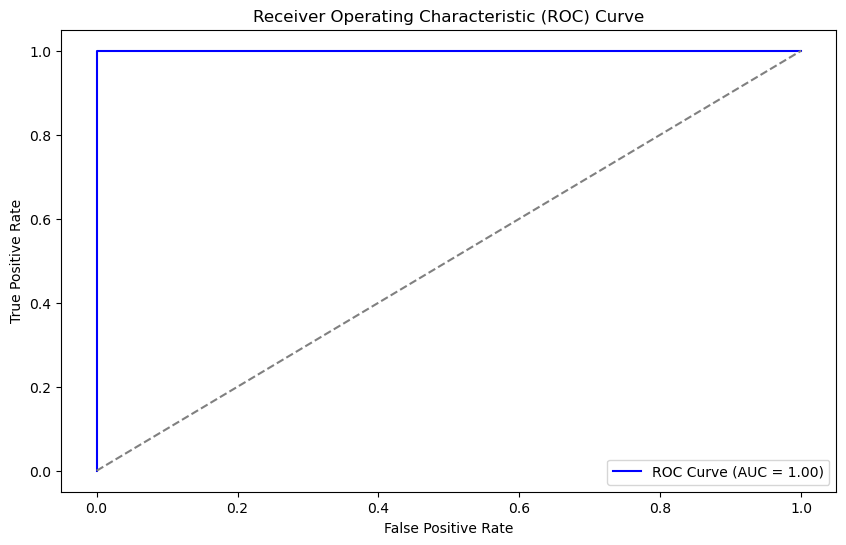

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve, pairwise_distances
from scipy.spatial.distance import cdist
from fcmeans import FCM  # Install using: pip install fuzzy-c-means
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# # Load and preprocess the Iris dataset
# Data = datasets.load_iris()
# X = Data.data
# y_true = (Data.target == 2).astype(int)  # Binary labels for ROC curve
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

file_path = r"D:\Research Related\30 Deep Robust Clustering with Mahalanobis Distance (DRCMD)\dataset\anemia.csv"

# Load the dataset into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Remove the last column
# Separate the features (X) and the target variable (y_true)
X = data.iloc[:, :-1]  # All columns except the last
y_true = data.iloc[:, -1]  # The last column
# # If all columns are features:
# X = data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
K = 3  # Number of clusters
Pth = 0.5  # Degree of belongingness threshold
dth = 2.0  # Distance threshold for filtering
max_iterations = 10  # Max iterations for Dunn Index maximization

# Function to calculate Dunn Index
def calculate_dunn_index(clusters, centroids):
    if len(centroids) < 2:
        return 0  # Avoid division by zero for single cluster
    min_inter_cluster_dist = np.min([
        np.linalg.norm(centroids[i] - centroids[j])
        for i in range(len(centroids)) for j in range(i + 1, len(centroids))
    ])
    max_intra_cluster_dist = max([
        np.max(cdist(clusters[k], [centroids[k]]))
        for k in range(len(centroids))
    ])
    return min_inter_cluster_dist / max_intra_cluster_dist

# Clustering ensemble method
def clustering_ensemble(X, K, Pth, dth):
    centroids = []
    clusters = []
    fcm = FCM(n_clusters=K)
    fcm.fit(X)
    fuzzy_memberships = fcm.u
    hard_clusters = fcm.predict(X)
    for k in range(K):
        cluster_points = X[hard_clusters == k]
        if len(cluster_points) > 0:  # Ensure non-empty clusters
            clusters.append(cluster_points)
            centroids.append(np.mean(cluster_points, axis=0))
    
    # Calculate Dunn Index
    dunn_index = calculate_dunn_index(clusters, centroids)

    # Iterative refinement
    for iteration in range(max_iterations):
        refined_clusters = []
        refined_centroids = []
        for i, cluster in enumerate(clusters):
            cluster_dists = pairwise_distances(cluster, [centroids[i]])
            belongingness_scores = 1 - (cluster_dists / np.sum(cluster_dists, axis=1, keepdims=True))
            filtered_points = cluster[belongingness_scores.flatten() >= Pth]
            
            if len(filtered_points) > 0:  # Only retain non-empty clusters
                refined_clusters.append(filtered_points)
                refined_centroids.append(np.mean(filtered_points, axis=0))
        
        if not refined_clusters:  # Exit if all clusters are filtered out
            print("All clusters filtered out during refinement.")
            break
        
        clusters = refined_clusters
        centroids = refined_centroids

        # Recompute Dunn Index
        new_dunn_index = calculate_dunn_index(clusters, centroids)
        if new_dunn_index <= dunn_index:
            break
        dunn_index = new_dunn_index
    
    if not clusters:  # Handle empty clusters after refinement
        print("No clusters remain after refinement.")
        return [], [], []

    # Distance-based filtering
    majority_cluster_idx = np.argmax([len(cluster) for cluster in clusters])
    majority_cluster = clusters[majority_cluster_idx]
    majority_centroid = centroids[majority_cluster_idx]

    outliers = []
    for cluster, centroid in zip(clusters, centroids):
        distances = pairwise_distances(cluster, [majority_centroid])
        outliers.extend(cluster[distances.flatten() > dth])
    
    return clusters, centroids, outliers

# Run the clustering ensemble with the iterative refinement
clusters, centroids, outliers = clustering_ensemble(X_scaled, K, Pth, dth)

# Results
num_outliers = len(outliers)
percentage_outliers = (num_outliers / len(X_scaled)) * 100

# Compute clustering metrics
cluster_labels = [np.argmin(cdist([x], centroids)) for x in X_scaled]
silhouette = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# ROC and AUC for binary outlier classification
fpr, tpr, _ = roc_curve(y_true, cluster_labels)
roc_auc = roc_auc_score(y_true, cluster_labels)

# Print Metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Number of Outliers:", num_outliers)
print("Percentage of Outliers:", f"{percentage_outliers:.2f}%")
print("AUC Value:", roc_auc)



# Visualization
# Density-Distance Decision Graph
outlier_scores = [1 - cdist([x], [centroids[np.argmin(cdist([x], centroids))]])[0, 0] for x in X_scaled]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(outlier_scores)), outlier_scores, c=outlier_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Data Point Index')
plt.ylabel('Outlier Score')
plt.show()

# Highlight Detected Outliers
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
if len(outliers) > 0:
    outliers = np.array(outliers)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', alpha=0.8)
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c='black', marker='x', s=200, label=f'Centroid {i+1}')
plt.title('Outlier Detection on Iris Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# 17/12/2024

Silhouette Score: 0.565
Davies-Bouldin Index: 0.719
S/DB Ratio: 0.785
Adjusted Rand Index (ARI): 0.169
F1-Score: 0.425
Hubness Score: 3.898
AUC Value: 0.499


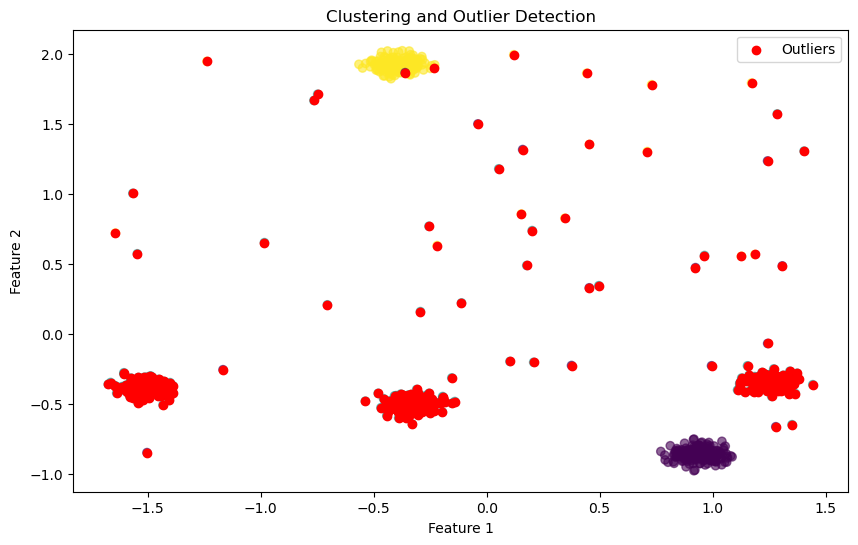

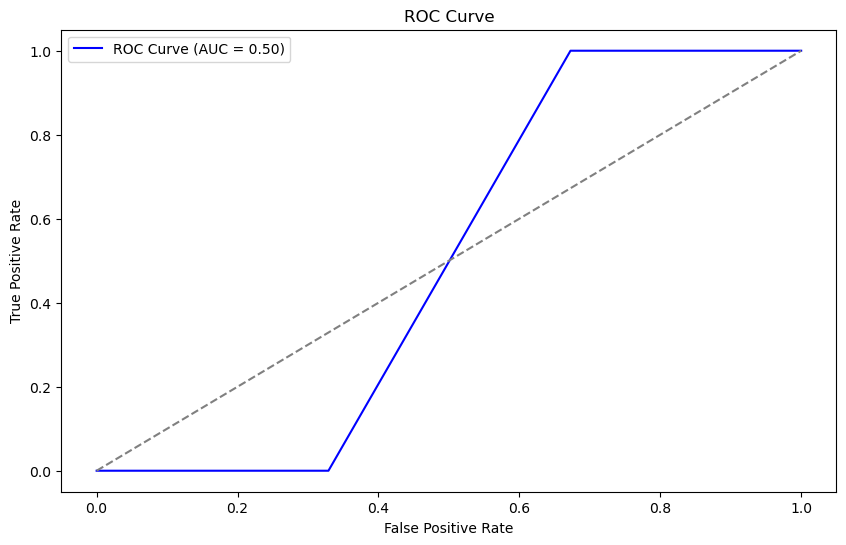

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve, adjusted_rand_score, f1_score
from scipy.spatial.distance import cdist
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)
X = data.iloc[:, :-1].values  # Features
y_true = data.iloc[:, -1].values  # True labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
K = 3  # Number of clusters
Pth = 0.5  # Belongingness threshold
dth = 2.0  # Distance threshold for filtering
max_iterations = 10  # Max iterations for refinement

# Function to calculate Dunn Index
def calculate_dunn_index(clusters, centroids):
    if len(centroids) < 2:
        return 0
    min_inter_cluster_dist = np.min([
        np.linalg.norm(centroids[i] - centroids[j])
        for i in range(len(centroids)) for j in range(i + 1, len(centroids))
    ])
    max_intra_cluster_dist = max([
        np.max(cdist(clusters[k], [centroids[k]]))
        for k in range(len(centroids))
    ])
    return min_inter_cluster_dist / max_intra_cluster_dist

# Function to compute Hubness Score
def hubness_score(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.std(hubness)

# Clustering ensemble method
def clustering_ensemble(X, K, Pth, dth):
    centroids = []
    clusters = []
    fcm = FCM(n_clusters=K)
    fcm.fit(X)
    hard_clusters = fcm.predict(X)
    for k in range(K):
        cluster_points = X[hard_clusters == k]
        if len(cluster_points) > 0:
            clusters.append(cluster_points)
            centroids.append(np.mean(cluster_points, axis=0))
    
    dunn_index = calculate_dunn_index(clusters, centroids)

    # Iterative refinement
    for iteration in range(max_iterations):
        refined_clusters = []
        refined_centroids = []
        for i, cluster in enumerate(clusters):
            cluster_dists = np.linalg.norm(cluster - centroids[i], axis=1)
            belongingness_scores = 1 - (cluster_dists / np.sum(cluster_dists))
            filtered_points = cluster[belongingness_scores >= Pth]
            if len(filtered_points) > 0:
                refined_clusters.append(filtered_points)
                refined_centroids.append(np.mean(filtered_points, axis=0))
        if not refined_clusters:
            break
        clusters, centroids = refined_clusters, refined_centroids
        new_dunn_index = calculate_dunn_index(clusters, centroids)
        if new_dunn_index <= dunn_index:
            break
        dunn_index = new_dunn_index
    
    outliers = []
    for cluster, centroid in zip(clusters, centroids):
        distances = np.linalg.norm(cluster - centroid, axis=1)
        outliers.extend(cluster[distances > dth])
    return clusters, centroids, np.array(outliers), hard_clusters

# Run the clustering ensemble method
clusters, centroids, outliers, predicted_labels = clustering_ensemble(X_scaled, K, Pth, dth)

# Metrics
silhouette = silhouette_score(X_scaled, predicted_labels)
davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)
s_db_ratio = silhouette / davies_bouldin
ari = adjusted_rand_score(y_true, predicted_labels)
f1 = f1_score(y_true, predicted_labels, average='macro')
hub_score = hubness_score(X_scaled)

# Outlier information
outliers_count = len(outliers)
outliers_percentage = (outliers_count / len(X_scaled)) * 100

# AUC and ROC
fpr, tpr, _ = roc_curve(y_true, predicted_labels)
roc_auc = roc_auc_score(y_true, predicted_labels)

# Print Results
# print("Silhouette Score:", silhouette)
# print("Davies-Bouldin Index:", davies_bouldin)
# print("S/DB Ratio:", s_db_ratio)
# print("Adjusted Rand Index (ARI):", ari)
# print("F1 Score:", f1)
# print("Hubness Score:", hub_score)
# print("Number of Outliers:", outliers_count)
# print(f"Percentage of Outliers: {outliers_percentage:.2f}%")
# print("AUC Value:", roc_auc)

# Results
print("Silhouette Score:", np.round(silhouette,3))
print("Davies-Bouldin Index:", np.round(davies_bouldin,3))
print("S/DB Ratio:", np.round(s_db_ratio,3))
print("Adjusted Rand Index (ARI):", np.round(ari,3))
print("F1-Score:", np.round(f1,3))
print("Hubness Score:", np.round(hub_score,3))
print("AUC Value:", np.round(roc_auc,3))

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=predicted_labels, cmap='viridis', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
plt.title('Clustering and Outlier Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
